## let's use PCA and make a suitabilit map: We will do:
1. collect all bands of landsat data for occurance point
2. examine the PCA and plot two component
3. use three PCA component and use logistic and linear regression and generate predictive map 
4. 


In [1]:
import os

# Change the working directory
os.chdir('C:/Users/IT/Downloads/2023')

# Verify the current working directory
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\IT\Downloads\2023


In [2]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, mean_squared_error
from rasterio import features, mask
from rasterio.plot import show
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from shapely.geometry import mapping
import rasterio 


In [3]:
# Paths to the Landsat bands
B2 = '2013-2023/2023/LC09_L1TP_114035_20230805_20230805_02_T1_B2.TIF'
B3 = '2013-2023/2023/LC09_L1TP_114035_20230805_20230805_02_T1_B3.TIF'
B4 = '2013-2023/2023/LC09_L1TP_114035_20230805_20230805_02_T1_B4.TIF'
B5 = '2013-2023/2023/LC09_L1TP_114035_20230805_20230805_02_T1_B5.TIF'
B10 = '2013-2023/2023/LC09_L1TP_114035_20230805_20230805_02_T1_B10.TIF'
B11 = '2013-2023/2023/LC09_L1TP_114035_20230805_20230805_02_T1_B11.TIF'

# List of band paths
bands = [B2, B3, B4, B5, B10, B11]

# Open the raster files and read them into arrays
raster_data = []
raster_meta = []

for band in bands:
    with rasterio.open(band) as src:
        raster_data.append(src.read(1))
        raster_meta.append(src.meta)

# Convert the raster data list to a numpy array
raster_data = np.array(raster_data)

# Get the spatial dimensions
height, width = raster_data.shape[1:]
print([height, width]) # overall map shape

[7811, 7681]


<Axes: >

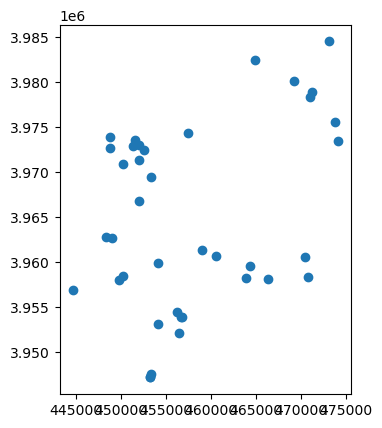

In [4]:
# Path to the shapefile containing examined points
shapefile_path = 'Daegu_point_korea_127/Daegu_point_korea_127.dbf'

# Read the shapefile using GeoPandas
gdf_points = gpd.read_file(shapefile_path)

# Reproject points to match the raster CRS if necessary
gdf_points = gdf_points.to_crs(raster_meta[0]['crs'])
gdf_points.plot()


In [5]:
# Extract raster values at point locations
def extract_raster_values_at_points(points, raster_data, transform):
    samples = []
    for point in points.geometry:
        row, col = (~transform) * (point.x, point.y)
        row, col = int(row), int(col)
        sample = raster_data[:, row, col]
        samples.append(sample)
    return np.array(samples)

# Get the transform from one of the raster metas (assuming all have the same transform)
transform = raster_meta[0]['transform']

# Extract raster values at the points
extracted_features = extract_raster_values_at_points(gdf_points, raster_data, transform)

# Print the extracted features
# print(extracted_features)

In [6]:
gdf_points.columns # examiine extracted data

Index(['Field1', 'POINT_X', 'POINT_Y', 'X_WGS84', 'Y_WGS84', 'M__flavigu',
       'N__caudatu', 'P__bengale', 'P__volans', 'geometry'],
      dtype='object')

In [7]:
#Occurrence point only for "'P__bengale'" species

In [8]:
# Add extracted features to GeoDataFrame with band labels
band_labels=['B2',' B3', 'B4', 'B5', 'B10', 'B11']
for i, band_label in enumerate(band_labels):
    gdf_points[band_label] = extracted_features[:, i]

# Print the GeoDataFrame with added features
gdf_points[band_labels+['P__bengale','geometry']].head(3)

,B2,B3,B4,B5,B10,B11,P__bengale,geometry
0,9188,8570,7357,21113,25061,24287,1,POINT (473053.232 3984455.627)
1,9203,8455,7121,17969,24855,24053,1,POINT (464843.709 3982410.498)
2,10633,9938,8092,7520,22877,22996,1,POINT (469252.617 3980053.640)


In [9]:
# we will execute PCA for bands first then use regresssion for presence data 

In [10]:
# Prepare data for PCA and regression
X = gdf_points[band_labels].values
y = gdf_points['P__bengale'].values

# Perform PCA
pca = PCA(n_components=2)  # Adjust number of components as needed
X_pca = pca.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

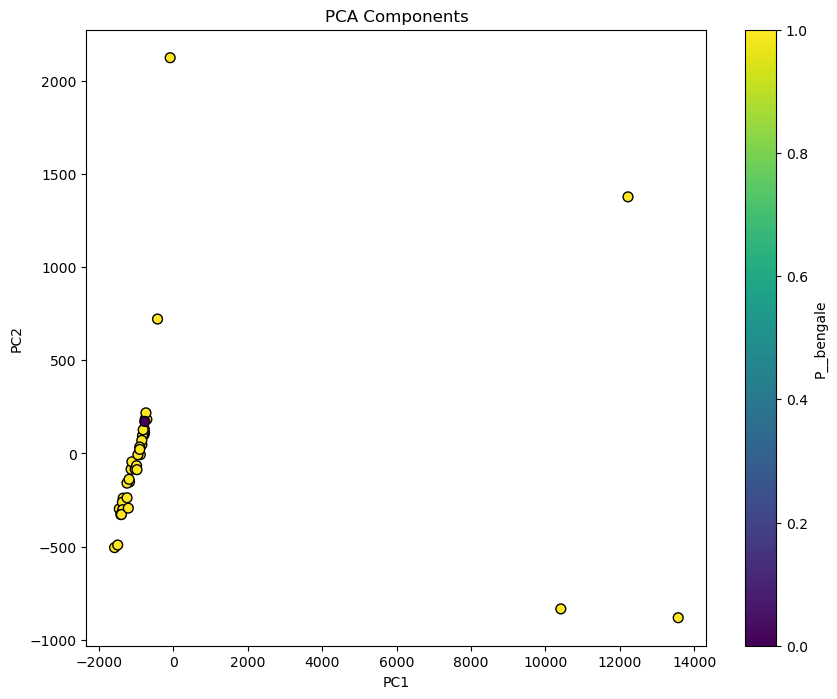

In [11]:
#Plotting PCA components
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
plt.title('PCA Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='P__bengale')
plt.show()

In [12]:
# Logistic Regression (glm)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Accuracy: {accuracy_logreg}")

Logistic Regression Accuracy: 1.0


In [13]:
# Linear Regression (OLS)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_test)
mse_linreg = mean_squared_error(y_test, y_pred_linreg)
print(f"Linear Regression Mean Squared Error: {mse_linreg}")


Linear Regression Mean Squared Error: 0.0016575315555029998


Let's predict through out the daegu area

<Axes: >

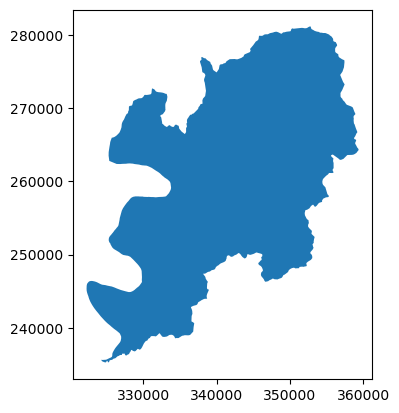

In [14]:
# Path to clip the shapefile containing Daegu boundary
shapefile_path = 'Daegu/Daegu.dbf'
# Read the shapefile using GeoPandas
gdf_boundary = gpd.read_file(shapefile_path)
gdf_boundary.plot()

In [15]:
np.shape(raster_data)

(6, 7811, 7681)

In [16]:
type(raster_data)

numpy.ndarray

In [17]:
raster_meta[0]['crs']

CRS.from_epsg(32652)

In [18]:
# Reproject the boundary to match the raster CRS if they are different
# can change using raster_crs = rasterio.crs.CRS.from_epsg(4326) 
gdf_boundary = gdf_boundary.to_crs(raster_meta[0]['crs'])


In [19]:
raster_data[0].flatten()


array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

Raster Band 1 flattened shape: (1887500,)


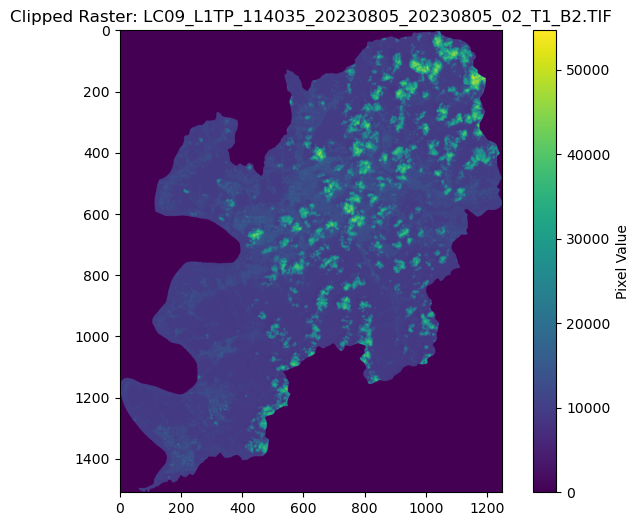

Raster Band 1 flattened shape: (1887500,)


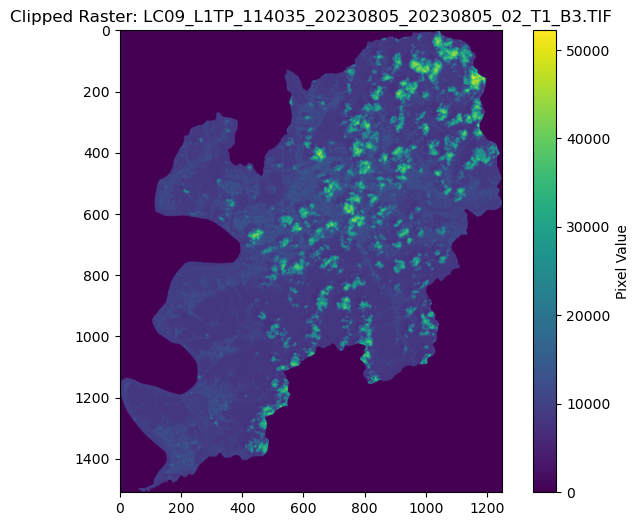

Raster Band 1 flattened shape: (1887500,)


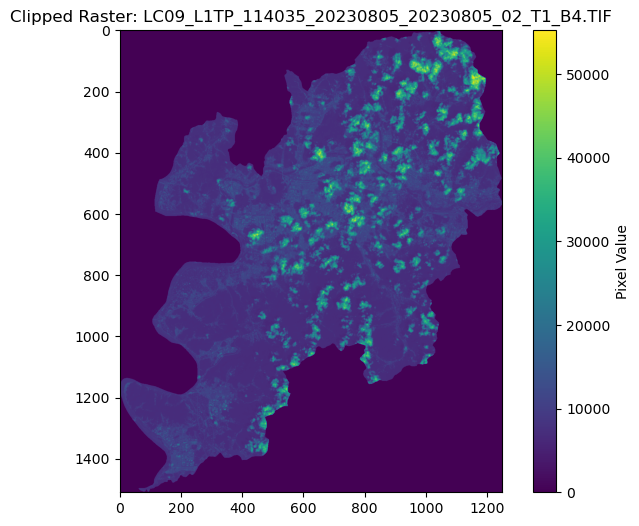

Raster Band 1 flattened shape: (1887500,)


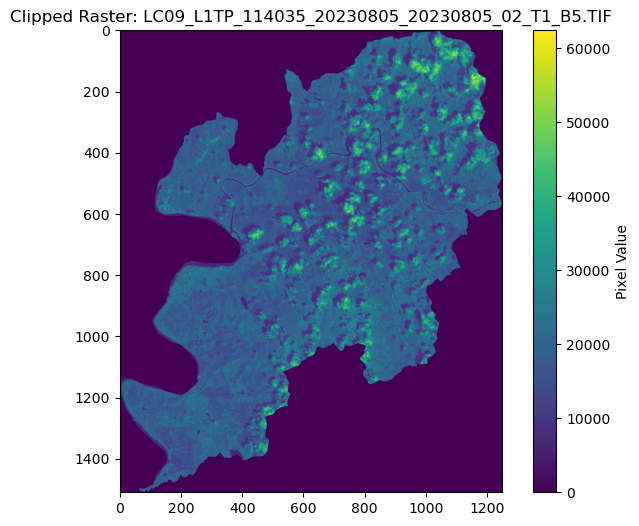

Raster Band 1 flattened shape: (1887500,)


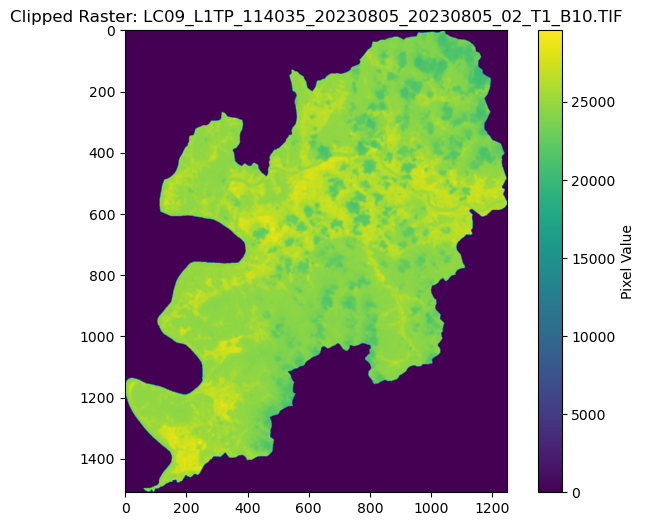

Raster Band 1 flattened shape: (1887500,)


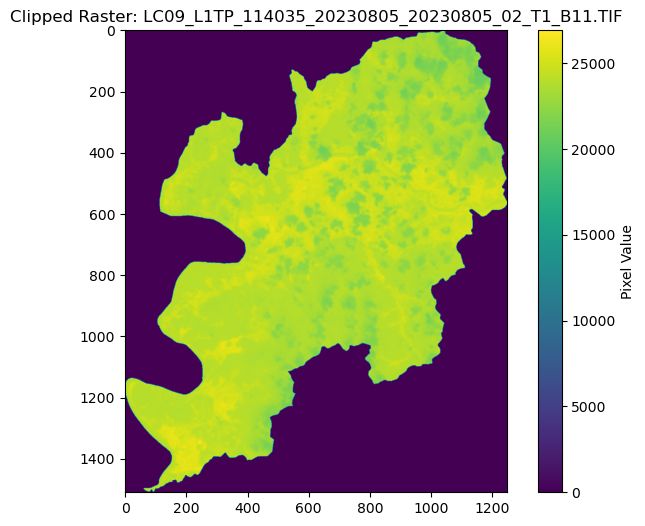

In [20]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import numpy as np
import os

# Path to clip the shapefile containing Daegu boundary
shapefile_path = 'Daegu/Daegu.dbf'

# Read the shapefile using GeoPandas
gdf_boundary = gpd.read_file(shapefile_path)

# List of paths to your raster files (replace with your actual paths)
# raster_paths = [
#     'path_to_raster_file1.tif',
#     'path_to_raster_file2.tif',
#     'path_to_raster_file3.tif',
#     # Add more paths as needed
# ]
raster_paths=bands
# Function to flatten each band of a raster
def flatten_raster(raster_data):
    num_bands, height, width = raster_data.shape
    flattened_data = []
    for band in range(num_bands):
        flattened_data.append(raster_data[band].flatten())
    return np.array(flattened_data)

# Loop through Raster Files and Clip
for raster_path in raster_paths:
    # Open the raster file
    raster = rasterio.open(raster_path)

    # Reproject the boundary to match the raster CRS if they are different
    gdf_boundary_reprojected = gdf_boundary.to_crs(raster.crs)

    # Get the geometry of the boundary as GeoJSON-like dict
    boundary_geojson = gdf_boundary_reprojected.geometry.values[0].__geo_interface__

    # Clip the raster data using the boundary
    clipped_raster, clipped_transform = mask(dataset=raster, shapes=[boundary_geojson], crop=True)

    # Close the raster file
    raster.close()

    # Flatten each band of the clipped raster data
    flattened_raster = flatten_raster(clipped_raster)

    # Optional: Visualize or process the flattened raster data (example: print flattened array shapes)
    for band_idx, band_data in enumerate(flattened_raster):
        print(f"Raster Band {band_idx + 1} flattened shape:", band_data.shape)

    # Optional: Visualize or process the clipped raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(clipped_raster[0], cmap='viridis')  # Assuming a single band, adjust as needed
    plt.colorbar(label='Pixel Value')
    plt.title(f'Clipped Raster: {os.path.basename(raster_path)}')
    plt.show()


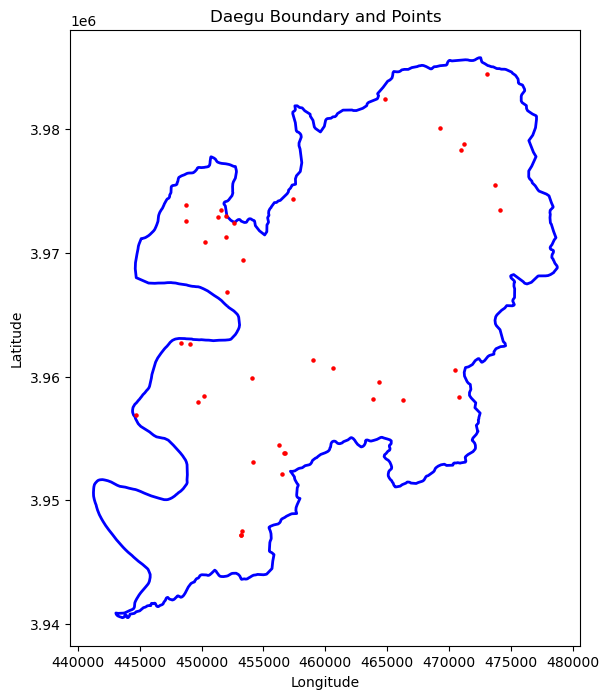

In [21]:
# Load Daegu boundary shapefile (replace with  actual file path)
daegu_boundary = gpd.read_file("Daegu/Daegu.dbf").to_crs(src.meta['crs']) 
# Plotting the boundary of Daegu
fig, ax = plt.subplots(figsize=(10, 8))  # Optional: Adjust figure size
daegu_boundary.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)

# Plotting the points on the same plot
gdf_points.plot(ax=ax, color='red', markersize=5)

# Adding titles and labels
ax.set_title('Daegu Boundary and Points')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Display the plot
plt.show()